# Progetto Deep Learning – Cyber Intrusion Detection con KDD Cup 1999


# Introduzione

 Il tema di questo progetto è la rilevazione automatica di attacchi informatici usando il dataset KDD Cup 1999, uno standard per l’intrusion detection.

L’idea è mettere a confronto modelli classici di machine learning e approcci di deep learning, con l’obiettivo di capire chi funziona meglio e perché.  

---

## Task e domande di ricerca

**Task principale:**  
Riconoscere automaticamente attacchi informatici in un dataset di connessioni di rete.

**Domande di ricerca:**  
1. Quale modello (MLP, Variational Autoencoder, Random Forest, One-Class SVM) offre le migliori prestazioni nell’identificare attacchi e traffico normale?
2. Quali caratteristiche (feature) incidono di più sulle decisioni automatiche dei modelli?

---

## Piano sperimentale

Per rispondere alle domande di ricerca, il progetto seguirà queste fasi operative:

1. **Analisi esplorativa dei dati:**  
   - Caricamento del dataset.
   - Analisi del dataset per capire:
      - la struttura dei dati
      - le feature disponibili
      - eventuali valori mancanti o anomali
      - la distribuzione delle classi (traffico normale e attacchi)
      - eventuali squilibri e possibili anomalie nei dati

2. **Preprocessing e preparazione dei dati:**  
   - Encoding delle feature categoriche.
   - Suddivisione in set di addestramento, validazione e test.
   - Scalatura dei dati.

3. **Progettazione e implementazione dei modelli:**  
   - Addestramento della Multi-Layer Perceptron (MLP).
   - Addestramento del Variational Autoencoder (VAE).
   - Addestramento della Random Forest (RF).
   - Addestramento della One-Class Support Vector Machine (One-Class SVM).

4. **Valutazione delle prestazioni e confronto:**  
   - Valutazione dei modelli con metriche standard (precision, recall, F1-score).
   - Confronto grafico delle prestazioni dei modelli.

5. **Analisi della trasparenza e delle feature più importanti:**  
   - Analisi delle feature più rilevanti per ciascun modello.
   - Commento sull’interpretabilità delle decisioni.

6. **Discussione finale e possibili estensioni:**  
   - Sintesi dei risultati ottenuti e delle risposte alle domande di ricerca.
   - Riflessioni su limiti, possibili miglioramenti e impatti pratici del lavoro.




# Analisi esplorativa dei dati

## Caricamento del dataset
In questa sezione carico ed esploro il dataset **KDD Cup 1999 (10% subset)**, un dataset utilizzato per la rilevazione di intrusioni e attacchi in reti informatiche.

Utilizzo solo il 10% del dataset per una questione di efficienza della RAM.

Inizio importando tutte le librerie di cui avrò bisogno:
- `google.colab.drive`: Accesso a Google Drive (da Colab)
- `pandas`: Gestione dati tabellari (DataFrames)
- `numpy`: Calcolo numerico (array)
- `matplotlib`: Creazione grafici
- `sklearn`: Strumenti per machine learning "classico" (divisone dati, metriche)
- `tensorflow`: Framework per deep learning
- `keras`: API per costruire reti neurali
- `joblib`: Salvataggio modelli ML.

Installo keras tuner per effettuare il tuning degli iperparametri in modo da averli già ottimizzati.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -q -U keras-tuner
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 4.5 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from eli5.sklearn import PermutationImportance
from sklearn.base import BaseEstimator, ClassifierMixin

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import numpy as np
import joblib
import eli5

Il file è stato precedentemente scaricato, è compresso in formato `.gz`.

In Colab lo decomprimerò per poterlo leggere.

In [ ]:
# Decomprimere il file .gz
!gunzip -k "/cyber_intrusion_detection/data/kddcup.data_10_percent.gz"
# L'opzione -k mantiene il file compresso originale

gzip: /content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/kddcup.data_10_percent already exists; do you wish to overwrite (y or n)? Y


Poiché il file originale non contiene nomi delle colonne, sto ridefinendo manualmente i nomi degli attributi standard del dataset per rendere il DataFrame più leggibile e gestibile.


In [ ]:
# Lista completa delle colonne (standard KDD Cup 99)
columns = [
  'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
  'wrong_fragment','urgent','hot','num_failed_logins','logged_in',
  'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
  'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
  'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
  'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
  'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
  'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
  'dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]

# Percorso del file decompresso
file_path = '/content/drive/MyDrive/Colab Notebooks/Cyber_Intrusion_Detection/data/kddcup.data_10_percent.gz'


# Carica il dataset
df = pd.read_csv(file_path, names=columns)

## Analisi del dataset
Ottenuto il DataFrame eseguo le prime esplorazioni.

In [ ]:
# Mostra le prime 5 righe del DataFrame
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
# Stampa la forma del DataFrame (numero di righe e colonne)
print("Shape del dataset (righe, colonne):", df.shape)

# Mostra informazioni sul DataFrame, inclusi i tipi di dati e la presenza di valori mancanti
df.info()

Shape del dataset (righe, colonne): (494021, 42)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compr

Il dataset contiene **494.021** connessioni di rete, ciascuna descritta da **42 colonne**:  
- **40 feature** tra numeriche (interi e float) e categoriche (stringhe),  
- più la colonna **target “label”** che indica la classe della connessione.

Le feature spaziano da dati relativi a durata, protocollo, servizi, flag, byte trasmessi, fino a metriche statistiche sulle connessioni.  

Non sono presenti valori mancanti, come si vede dal numero di valori non nulli uguale al totale delle righe e i dati sono puliti.  

In [ ]:
# Conta e mostra la frequenza di ogni valore unico nella colonna 'label'
label_counts = df['label'].value_counts()
print(label_counts)


label
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64


Prima di iniziare la modellazione, verifico la distribuzione delle classi nel dataset: quante connessioni sono “safe” (normali) e quante sono “attack”.  
Poiché le etichette originali indicano diversi tipi di attacco, le trasformo in una versione binaria (“safe” vs “attack”).

Per visualizzare questa distribuzione utilizzo la libreria **matplotlib**, così da identificare subito eventuali squilibri tra le classi che potrebbero influenzare l’addestramento e la valutazione dei modelli.



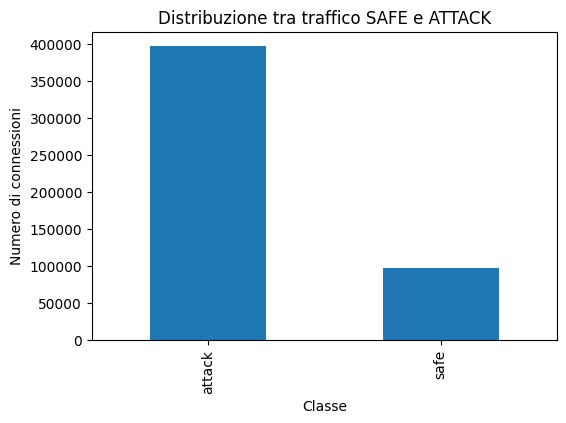

In [ ]:
# Crea una colonna binaria per la classificazione "safe" vs "attack"
df['target'] = df['label'].apply(lambda x: 'safe' if x == 'normal.' else 'attack')

# Visualizza la distribuzione aggiornata
df['target'].value_counts().plot(kind='bar', figsize=(6, 4))
plt.title('Distribuzione tra traffico SAFE e ATTACK')
plt.ylabel('Numero di connessioni')
plt.xlabel('Classe')
plt.show()


Dalla distribuzione si nota che la classe più rappresentata è “attack”, mentre l’altra classe è meno frequente.
Il dataset risulta quindi sbilanciato e sarà importante tenere conto di questo sbilanciamento nelle fasi successive, valutando metriche come precision, recall e F1-score, e considerando se necessario tecniche per bilanciare i dati.


# Preprocessing e preparazione dei dati

## Encoding delle feature categoriche

Dall’analisi esplorativa, ho notato che alcune colonne del dataset (`protocol_type`, `service`, `flag`, `target`) sono di tipo `object`, cioè contengono valori categorici rappresentati come stringhe.

Poiché i modelli di machine learning e deep learning lavorano solo con dati numerici, è necessario convertire queste variabili categoriche in formato numerico.  
Per farlo applico il **One Hot Encoding**, che trasforma ogni possibile valore delle colonne categoriche in una nuova colonna binaria (0 o 1).


In [ ]:
# Lista delle colonne categoriche da codificare
categorical_cols = ['protocol_type', 'service', 'flag']

# Applica il One Hot Encoding alle colonne categoriche
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# Visualizza le prime colonne per controllo
print(df_encoded.columns[:20])  # solo le prime 20 per non intasare l’output

# Visualizza le prime righe per verifica
df_encoded.head()


Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count'],
      dtype='object')


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,181,5450,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
1,0,239,486,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
2,0,235,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
3,0,219,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False
4,0,217,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,True,False


La variabile `target` rappresenta la classe binaria del problema, distinguendo tra traffico “safe” (normale) e “attack” (intrusione).
Procedo quindi a codificare `safe` come 0 e `attack` come 1.

In [ ]:
# Controllo che la colonna sia corretta
print(df_encoded['target'].value_counts())

# Codifica binaria
df_encoded['target'] = df_encoded['target'].map({'safe': 0, 'attack': 1})

# Verifica del risultato
print(df_encoded['target'].value_counts())


target
attack    396743
safe       97278
Name: count, dtype: int64
target
1    396743
0     97278
Name: count, dtype: int64


Rimuovo inoltre la colonna label contentente la stringa relativa al tipo di attacco.

In [ ]:
df_encoded = df_encoded.drop(columns=['label'])

## Suddivisione in set di addestramento, validazione e test

Suddivido il dataset in tre parti: training set, validation set e test set.  
Lo split viene effettuato in modo stratificato sulla colonna `target` per mantenere la stessa proporzione tra classi in ogni sottoinsieme.



In [ ]:
# Prima separo le feature dal target
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']

# Split in train (70%) e temp (30%)
train_set, temp_set, label_train, label_temp = train_test_split(
  X, y, test_size=0.3, random_state=42, stratify=y
)

# Split di temp in validation (15%) e test (15%)
val_set, test_set, label_val, label_test = train_test_split(
  temp_set, label_temp, test_size=0.5, random_state=42, stratify=label_temp
)

print(f"Train set: {train_set.shape}")
print(f"Validation set: {val_set.shape}")
print(f"Test set: {test_set.shape}")


Train set: (345814, 118)
Validation set: (74103, 118)
Test set: (74104, 118)


## Scalatura dei dati
Effettuo una scalatura dei dati numerici in modo che le features abbiano lo stesso intervallo, facilitando la convergenza degli algoritmi durante il training.

Utilizzo la funzione MinMaxScaler, `fit_transform` trova i parametri sul training set e li applica, `transform` utilizza quei parametri anche su validation e test set.

In [ ]:
# Normalizzo tutte le feature nell’intervallo [0, 1]
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)  # Fit e trasformazione sul training
val_set = scaler.transform(val_set)          # Trasformazione su validation
test_set = scaler.transform(test_set)        # Trasformazione su test

# Progettazione e implementazione dei modelli

## Addestramento della Multi-Layer Perceptron (MLP)

In questa sezione implemento e addestro una rete neurale densamente connessa  per la classificazione.
La rete utilizza come input le feature preprocessate e viene valutata sul validation e test set.

Definisco i valori minimi e massimi per la ricerca automatica del numero di `layers`, di `units`, del `dropout` e del `learning rate`, così da trovare la configurazione ottimale tramite tuning.
La rete è composta da livelli densamente connessi (Dense) con attivazione `ReLU` nei layer nascosti e funzione di attivazione `Sigmoid` nell’output, dato che il problema è di classificazione binaria tra `safe` (0) e `attack` (1).
Compilo la rete utilizzando l’ottimizzatore `Adam` che adatta dinamicamente il learning rate per ogni parametro, facilitando una convergenza efficiente durante l'addestramento, la funzione di perdita `binary cross entropy` che è adatta ad un problema di classificazione binario misurando la differenza tra le probabilità predette dal modello e le vere etichette, e come metriche `precision`, `recall` e `f1 score`, ideali per dataset sbilanciati come questo.

In [ ]:
input_dim = train_set.shape[1]  # Numero di feature in input

def model_builder(hp):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(input_dim,)))  # Input layer

    # Scelgo il numero di hidden layer (tra 1 e 3)
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1)

    for i in range(num_hidden_layers):
        # Scelgo il numero di unità del layer corrente
        units = hp.Int(f'units_layer_{i}', min_value=64, max_value=128, step=32)
        model.add(layers.Dense(units, activation='relu'))  # Hidden layer con ReLU

        # Scelgo il valore di dropout per questo layer
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.4, step=0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    # Output layer per classificazione binaria
    model.add(layers.Dense(1, activation='sigmoid'))

    # Scelgo il learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    # Compilo il modello con Adam, loss binaria e metriche di interesse
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

Configuro `Hyperband tuner` per ottimizzare gli iperparametri del modello, impostando come obiettivo la massimizzazione della `recall` sul `validation set`, minimizzando i falsi negativi e privilegiando la rilevazione di tutti gli attacchi anche a costo di un aumento di falsi positivi. La ricerca su massimo 20 `epochs` con `factor` 3. I risultati migliori saranno salvati in una cartella dedicata.

In [ ]:
tuner = kt.Hyperband(
  model_builder,
  objective='val_recall',
  max_epochs=20,
  factor=3,
  directory='/cyber_intrusion_detection/',
  project_name='MLP_tuning'
)

Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/Intrusion Detection/tuner0.json


Imposto una `callback` di `early stopping` con `patience` di 5 epoche monitorando la `loss` del `validation set` per prevenire l'`overfitting`.

In [ ]:
early_stop_mlp = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

La ricerca degli `iperparametri` viene quindi avviata sul `training set`, con validazione sul `validation set`.


In [ ]:
tuner.search(train_set, label_train, epochs=20, validation_data=(val_set, label_val), callbacks=[early_stop_mlp])

Trial 28 Complete [00h 12m 12s]
val_recall: 0.9997143149375916

Best val_recall So Far: 0.9997647404670715
Total elapsed time: 01h 57m 06s

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_hidden_layers
96                |128               |units_layer_0
0.2               |0.2               |dropout_0
0.0005            |0.0005            |learning_rate
64                |128               |units_layer_1
0.4               |0.3               |dropout_1
96                |64                |units_layer_2
0.2               |0.4               |dropout_2
20                |20                |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |0                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/20
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0387 - precision: 0.9919 - recall: 0.9934 - val_loss: 0.0028 - val_precision: 0.9996 - val_re

La ricerca è terminata e vengono riportati il numero ottimale di unità per layer nascosto, il numero di layer, il dropout e il learning rate.

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

optimal_num_layers = best_hps.get('num_hidden_layers')
optimal_learning_rate = best_hps.get('learning_rate')

print("The hyperparameter search is complete.")

print("Optimal units per hidden layer:")
for i in range(optimal_num_layers):
  print(f"  Layer {i+1}: {best_hps.get(f'units_layer_{i}')} units")

print(f"The optimal number of hidden layers is: {optimal_num_layers}")

print("Optimal dropout per hidden layer:")
for i in range(optimal_num_layers):
  print(f"  Layer {i+1}: {best_hps.get(f'dropout_{i}')}")

print(f"The optimal learning rate is: {optimal_learning_rate}")

The hyperparameter search is complete.
Optimal units per hidden layer:
  Layer 1: 96 units
  Layer 2: 64 units
The optimal number of hidden layers is: 2
Optimal dropout per hidden layer:
  Layer 1: 0.2
  Layer 2: 0.4
The optimal learning rate is: 0.0005


In [ ]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 96)             │        11,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,697 (69.13 KB)

 Trainable params: 17,697 (69.13 KB)

 Non-trainable params: 0 (0.00 B)

Il modello ottimizzato è una rete neurale sequenziale con `due layers` nascosti composto dal primo con `96` neuroni, seguito da un layer di `dropout` con tasso `0.2`, il secondo con `64` neuroni, seguito da un layer di `dropout` con tasso `0.4`. L’output è uno strato denso con un singolo neurone e attivazione sigmoid, adatto per una classificazione binaria. La rete conta complessivamente `17.697 parametri` addestrabili. Il `learning rate` ha un tasso di `0.0005`.

Il modello costruito con gli iperparametri ottimali viene addestrato per `50 epoche`, monitorando `recall` e `precision` durante il `training` e la `validazione`. Viene identificata l’epoca con il miglior valore di recall sul validation set, utilizzata per determinare il numero ottimale di epoche. L'early stopping fermerà l'addestramento quando non troverà miglioramenti entro 5 epoche.

In [ ]:
history = model.fit(train_set, label_train, epochs=50, validation_data=(val_set, label_val), callbacks=[early_stop_mlp])

val_recall_per_epoch = history.history['val_recall']
best_epoch = val_recall_per_epoch.index(max(val_recall_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0381 - precision: 0.9913 - recall: 0.9928 - val_loss: 0.0030 - val_precision: 0.9994 - val_recall: 0.9995
Epoch 2/50
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.0036 - precision: 0.9996 - recall: 0.9994 - val_loss: 0.0020 - val_precision: 0.9997 - val_recall: 0.9996
Epoch 3/50
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0027 - precision: 0.9997 - recall: 0.9995 - val_loss: 0.0019 - val_precision: 0.9997 - val_recall: 0.9996
Epoch 4/50
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0025 - precision: 0.9997 - recall: 0.9995 - val_loss: 0.0018 - val_precision: 0.9998 - val_recall: 0.9996
Epoch 5/50
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0024 - precision: 0.9998 - recall: 0.9995 - val_loss: 0.0023 - val_precision: 0.9999 - val_recall: 0.9990
Epoch 6/50
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0024 - precision: 0.9997 - recall: 0.9995 - val_loss: 0.0018 - val_p

Viene visualizzato l’andamento di `loss`, `precision` e `recall` durante l’addestramento e la validazione per valutare l’evoluzione delle prestazioni del modello nel tempo, tramite `matplotlib` stampo i grafici delle curve.



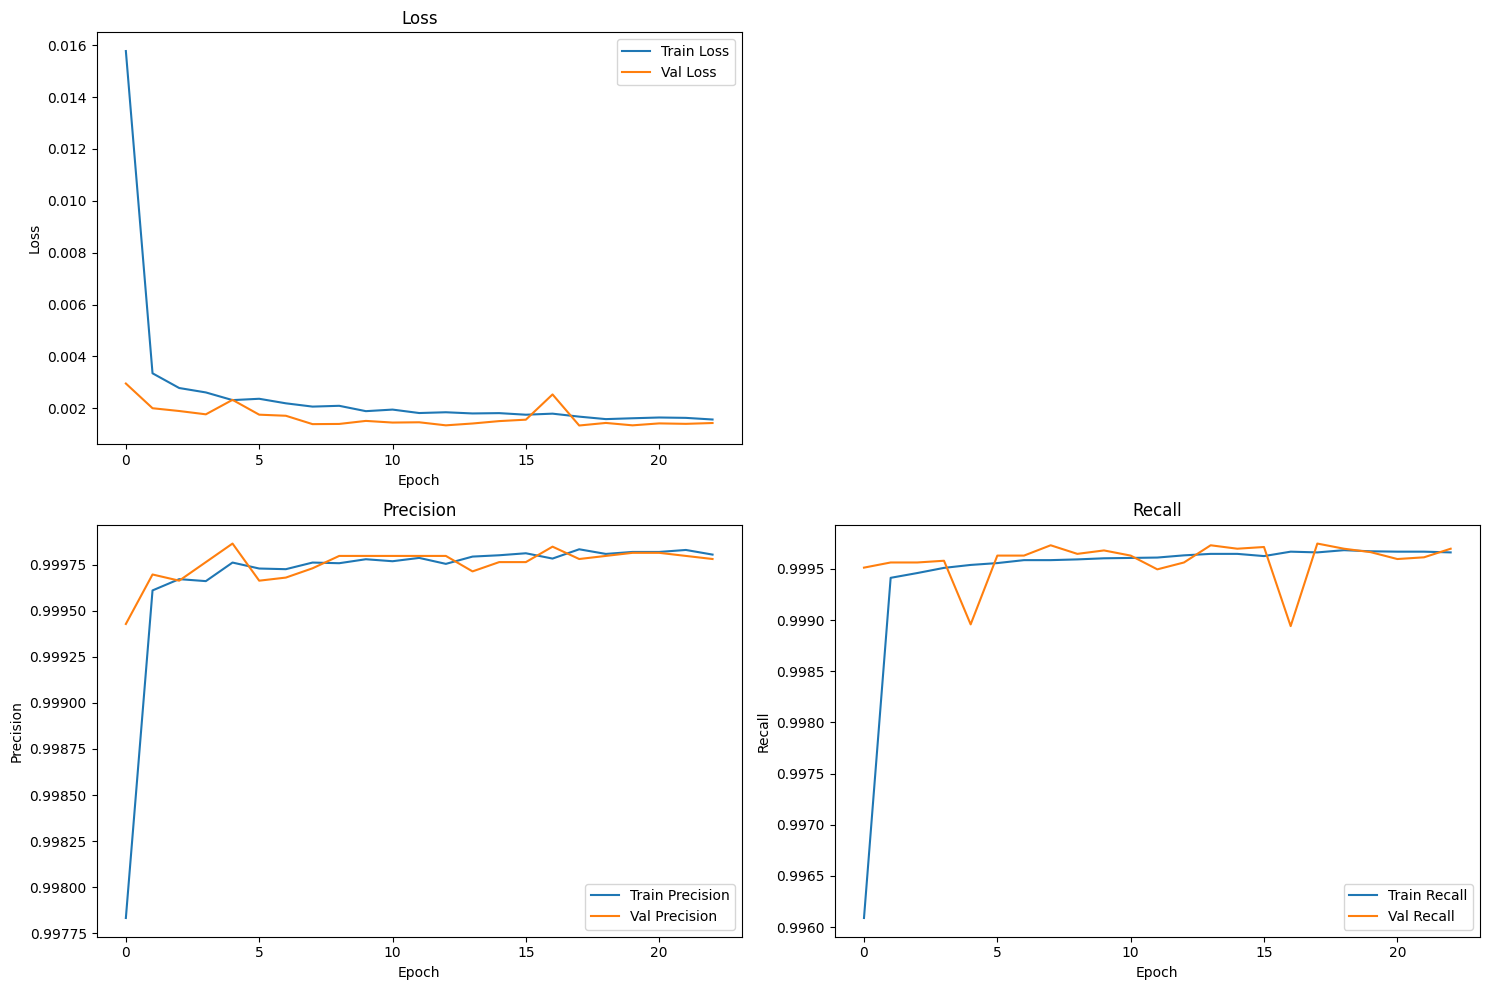

In [ ]:
history_dict = history.history

plt.figure(figsize=(15, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(history_dict['recall'], label='Train Recall')
plt.plot(history_dict['val_recall'], label='Val Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(history_dict['precision'], label='Train Precision')
plt.plot(history_dict['val_precision'], label='Val Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()


plt.tight_layout()
plt.show()

La `loss` cala rapidamente nelle prime epoche, sia su train che su validation, stabilizzandosi poi su valori molto bassi, intorno a 0.002. Non si presenta overfitting, i valori sono abbastanza simili. La rete impara molto velocemente.

La `recall` è abbastanza alta da subito, circa 0.9995, salendo subito a quasi 1 e rimanendo stabile. I valori sono altissimi sia su train che validation con piccole oscillazioni.

La `precision` sale subito a quasi 0.99975, già dopo pochissime epoche, le linee di train e validation sono praticamente sovrapposte.

Si costruisce il modello con i migliori iperparametri trovati e lo riaddestriamo per il numero ottimale di epoche, monitorando le metriche anche sul validation set.

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Ri-addestra il modello
history_second_fit = hypermodel.fit(train_set, label_train, epochs=best_epoch, validation_data=(val_set, label_val))
history_dict = history_second_fit.history

Epoch 1/18
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.0478 - precision: 0.9961 - recall: 0.9843 - val_loss: 0.0027 - val_precision: 0.9997 - val_recall: 0.9995
Epoch 2/18
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0035 - precision: 0.9995 - recall: 0.9994 - val_loss: 0.0023 - val_precision: 0.9998 - val_recall: 0.9994
Epoch 3/18
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0028 - precision: 0.9996 - recall: 0.9994 - val_loss: 0.0019 - val_precision: 0.9997 - val_recall: 0.9995
Epoch 4/18
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0026 - precision: 0.9997 - recall: 0.9995 - val_loss: 0.0019 - val_precision: 0.9997 - val_recall: 0.9996
Epoch 5/18
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 0.0024 - precision: 0.9997 - recall: 0.9996 - val_loss: 0.0017 - val_precision: 0.9997 - val_recall: 0.9996
Epoch 6/18
10807/10807 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0024 - precision: 0.9997 - recall: 0.9995 - val_loss: 0.0016 - val_p

Salvo il modello su un'apposita cartella per poterlo riutilizzare in futuro.

In [ ]:
hypermodel.save('/cyber_intrusion_detection/models/mlp.h5')

In [ ]:
mlp_model = keras.models.load_model('/cyber_intrusion_detection/models/mlp.h5')

## Addestramento del Variational Autoencoder (VAE)

Ora passo all'addestramento del Variational Autoencoder con l'obiettivo di ricostruire le connessioni normali. Una volta che la rete sarà ben allenata su questi dati, quando le verranno presentate connessioni relative ad attacchi, il modello non sarà in grado di ricostruirle correttamente: ciò si tradurrà in un errore di ricostruzione elevato, che permette di distinguerle da quelle normali.

In questa versione non ho utilizzato tuner ma ho fatto alcuni tentativi manualmente per trovare dei parametri più efficienti.

Definisco la struttura dell’`encoder` che prende in ingresso solo le connessioni normali e le proietta in uno `spazio latente` di dimensione 4.

L’architettura dell’encoder prevede alcuni livelli densi con attivazione `ReLU`, seguiti da due uscite separate che rappresentano la media `z_mean` e la varianza logaritmica `z_log_var` della distribuzione latente.

Questo approccio consente di ottenere una rappresentazione compressa dei dati, regolarizzata in modo probabilistico. A differenza di un autoencoder tradizionale, il VAE permette anche di generare nuovi dati realistici campionando dallo spazio latente.

In [ ]:
latent_dim = 4  # Dimensione dello spazio latente

# Seleziono solo le connessioni normali per il training del VAE
X_train_normal = train_set[label_train == 0]
X_val_normal = val_set[label_val == 0]
X_test_normal = test_set[label_test == 0]

input_dim = X_train_normal.shape[1]  # Numero di feature in input

# Definizione dell'encoder del VAE
encoder_inputs = tf.keras.Input(shape=(input_dim,))
x = tf.keras.layers.Dense(64, activation="relu")(encoder_inputs)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)

# Due output separati: media e log-varianza dello spazio latente
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")


Definisco un layer personalizzato chiamato `Sampler`, che implementa il trucco della riparametrizzazione. Questo layer serve a campionare, in modo `differenziabile`, i punti dallo `spazio latente` utilizzando la `media` e la `varianza logaritmica` calcolate dall’encoder.

Genero una variabile casuale `epsilon` con valori estratti da una distribuzione normale standard. Questo rumore viene usato per campionare nuovi punti dallo spazio latente in modo stocastico.

In [ ]:
class Sampler(tf.keras.layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Genero rumore gaussiano standard
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Applico la formula della riparametrizzazione
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Definisco ora la struttura del `decoder` del Variational Autoencoder. Il decoder prende in ingresso un vettore dallo spazio latente, che può essere sia la rappresentazione di una connessione normale sia un punto campionato casualmente.

La sua architettura prevede una serie di livelli densi con attivazione `ReLU`, che progressivamente aumentano la dimensionalità della rappresentazione. L’ultimo layer produce un output della stessa dimensione dell’input originale, applicando una funzione di attivazione `sigmoide` per garantire che i valori ricostruiti siano compresi nell’intervallo desiderato.

In questo modo, il decoder impara a ricostruire una connessione di rete a partire da un punto nello spazio latente, permettendo di valutare l’accuratezza della ricostruzione e quindi di rilevare eventuali anomalie.

In [ ]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))  # Input: vettore dallo spazio latente

# Serie di livelli densi che aumentano la dimensionalità
x = tf.keras.layers.Dense(16, activation="relu")(latent_inputs)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)

# Output layer: ricostruisce l'input originale, valori tra 0 e 1
decoder_outputs = tf.keras.layers.Dense(input_dim, activation="sigmoid")(x)

# Definisco il modello decoder
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

In questa cella definisco la classe personalizzata `VAE`, che estende `tf.keras.Model` e incapsula tutta la logica del Variational Autoencoder.

Costruttore `__init__`: Riceve `encoder` e `decoder`, `istanzia` un livello di campionamento `Sampler` e `definisce` tre `tracker` di `loss` per monitorare la `perdita totale`, la `perdita di ricostruzione` e la `componente KL` durante l’addestramento.

Proprietà `metrics`: `Restituisce` i tracker delle `metriche` che vengono visualizzati durante training e validazione.

Metodo `train_step`: Implementa la `logica` di `training` batch-wise. `Calcola` la rappresentazione latente `media e varianza logaritmica`, effettua il `campionamento`, genera la `ricostruzione` e computa sia la perdita di ricostruzione `MSE` che la penalizzazione di regolarizzazione `KL divergence`. Aggiorna le metriche e applica i gradienti.

Metodo `test_step`: Analogamente a train_step, esegue la `validazione` sui dati di input, calcolando le stesse metriche.

Metodo `call`: Definisce la `forward pass` del modello: prende un input, calcola media e varianza logaritmica, campiona un punto latente e lo `ricostruisce` tramite il decoder.

In [ ]:
class VAE(tf.keras.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Tracker per le metriche di loss
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        # Restituisco le metriche da tracciare durante training/validazione
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        # Implemento la logica di training batch-wise
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = self.decoder(z)

            # Loss di ricostruzione (MSE tra input e output)
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(data, reconstruction))

            # Penalità di regolarizzazione KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            total_loss = reconstruction_loss + kl_loss

        # Calcolo e applico i gradienti
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Aggiorno le metriche
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def test_step(self, data):
        # Logica di validazione/test (analoga al train_step)
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data

        z_mean, z_log_var = self.encoder(x)
        z = self.sampler(z_mean, z_log_var)
        reconstruction = self.decoder(z)

        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x, reconstruction))
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def call(self, inputs):
        # Forward pass del VAE: da input a output ricostruito passando per lo spazio latente
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampler(z_mean, z_log_var)
        return self.decoder(z)

Definisco l'`early stoping` per la fase di training con le stesse metriche usate per la MLP.

In [ ]:
early_stop_vae = tf.keras.callbacks.EarlyStopping(
    monitor='val_total_loss',
    mode='min',
    patience=5,
    restore_best_weights=True
    )

Istanzio il modello VAE che contiene encoder e decoder.

Compilo con l'ottimizzatore `Adam`, il parametro `run_eagerly=True` viene attivato per facilitare il debug durante lo sviluppo, il parametro `loss='mse'` è opzionale dato che la funzinoe di perdita è già implementata su VAE.

Nella fase di fit il modello viene quindi addestrato esclusivamente sulle connessioni normali, per 30 `epochs` e con `batch size` di 128, la validazione è sempre sul `validation set`, imposto come callback l'`early stopping` implementato precedentemente.

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(), run_eagerly=True, loss='mse')
history_vae = vae.fit(
  X_train_normal,
  epochs=30,
  batch_size=128,
  validation_data=(X_val_normal, X_val_normal),
  callbacks=[early_stop_vae]
  )

Epoch 1/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 67s 123ms/step - kl_loss: 7.9139e-04 - reconstruction_loss: 0.0745 - total_loss: 0.0753 - val_kl_loss: 2.9632e-07 - val_reconstruction_loss: 0.0174 - val_total_loss: 0.0174
Epoch 2/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 66s 123ms/step - kl_loss: 1.9945e-07 - reconstruction_loss: 0.0173 - total_loss: 0.0173 - val_kl_loss: 1.2952e-07 - val_reconstruction_loss: 0.0172 - val_total_loss: 0.0172
Epoch 3/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - kl_loss: 3.3469e-08 - reconstruction_loss: 0.0172 - total_loss: 0.0172 - val_kl_loss: 1.1789e-07 - val_reconstruction_loss: 0.0172 - val_total_loss: 0.0172
Epoch 4/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 64s 121ms/step - kl_loss: 2.4953e-08 - reconstruction_loss: 0.0172 - total_loss: 0.0172 - val_kl_loss: 1.1669e-07 - val_reconstruction_loss: 0.0172 - val_total_loss: 0.0172
Epoch 5/30
532/532 ━━━━━━━━━━━━━━━━━━━━ 64s 121ms/step - kl_loss: 2.3502e-08 - reconstruction_loss: 0.0173 - total_loss: 0.0173 - val_kl_loss: 1.134

Verifico con i grafici delle loss su training e validazione come si è comportato il modello durante l'addestramento.

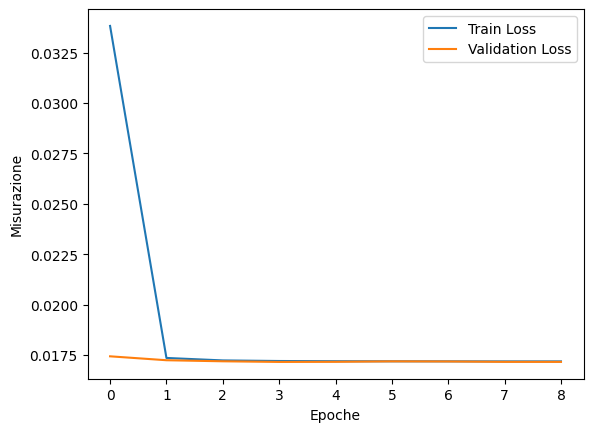

In [ ]:
plt.plot(history_vae.history["total_loss"], label="Train Loss")
plt.plot(history_vae.history["val_total_loss"], label="Validation Loss")
plt.legend()
plt.xlabel('Epoche')
plt.ylabel('Misurazione')
plt.show()

La trainig loss cala rapidamente nelle prime epoche e si stabilizza su valori bassi.

La validation loss è già bassa dall'inizio rimanendo quasi costante e vicinissima a quella di training.

Le due curve sono quasi sovrapposte dopo pochissime epoche, quindi il modello converge rapidamente, non c'è segnale di overfitting nemmeno qui.

Il modello riesce quindi a ricostruire bene i dati normali sia su training che sulla validazione.

Non potendo salvare il modello salvo i pesi migliori trovati nella fase di training ed eseguo nuovamente la compilazione con i parametri precedenti.

In [ ]:
# Creo un input dummy per inizializzare il modello VAE (richiesto da Keras prima di salvare i pesi)
dummy_input = tf.convert_to_tensor(np.zeros((1, train_set.shape[1])), dtype=tf.float32)
vae(dummy_input)

# Salvo i pesi del modello VAE su file
vae.save_weights('/cyber_intrusion_detection/models/vae.weights.h5')

In [ ]:
# Istanzio e compilo il modello VAE (con encoder e decoder già definiti)
vae_model = VAE(encoder, decoder)
vae_model.compile(optimizer=tf.keras.optimizers.Adam())

# Inizializzo il modello passando un input dummy (richiesto da Keras)
dummy_input = tf.convert_to_tensor(np.zeros((1, train_set.shape[1])), dtype=tf.float32)
vae_model(dummy_input)

# Carico i pesi precedentemente salvati
vae_model.load_weights('/cyber_intrusion_detection/models/vae.weights.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Calcolo l'errore di ricostruzione su tutte le connessioni presenti nel test set.

Ottengo la media `z_mean` e la varianza logaritmica `z_log_var` delle rappresentazioni latenti per ogni connessione, genero la ricostruzione tramite il decoder e calcolo per ciascun campione la differenza quadratica media `MSE` tra input originale e ricostruito.

Successivamente, separo gli errori in due gruppi: quelli relativi alle connessioni normali e quelli associati agli attacchi, sfruttando le etichette reali del test set.

Infine, visualizzo tramite istogrammi la distribuzione degli errori di ricostruzione per ciascun gruppo, per evidenziare la capacità del modello di distinguere tra traffico normale e attacchi in base all’errore commesso nella ricostruzione.

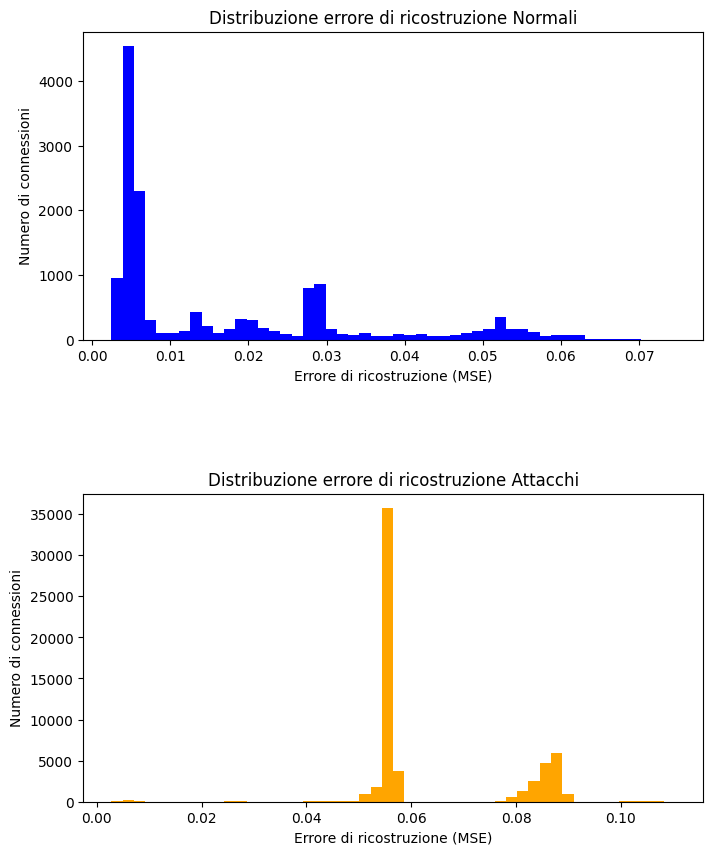

In [ ]:
# Calcolo rappresentazioni latenti e ricostruzioni sul test set
z_mean, z_log_var = vae_model.encoder(test_set)
z = vae_model.sampler(z_mean, z_log_var)
reconstructions = vae_model.decoder(z)

# Calcolo l'errore di ricostruzione (MSE) per ogni campione del test set
reconstruction_errors = np.mean((test_set - reconstructions.numpy())**2, axis=1)

# Separo gli errori tra connessioni normali e attacchi, in base alle etichette reali
errors_normali = reconstruction_errors[label_test == 0]
errors_attacchi = reconstruction_errors[label_test == 1]

# Visualizzo la distribuzione degli errori tramite istogrammi separati per normali e attacchi
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
plt.subplots_adjust(hspace=0.5)

axes[0].hist(errors_normali, bins=50, color='blue')
axes[0].set_xlabel("Errore di ricostruzione (MSE)")
axes[0].set_ylabel("Numero di connessioni")
axes[0].set_title("Distribuzione errore di ricostruzione Normali")

axes[1].hist(errors_attacchi, bins=50, color='orange')
axes[1].set_xlabel("Errore di ricostruzione (MSE)")
axes[1].set_ylabel("Numero di connessioni")
axes[1].set_title("Distribuzione errore di ricostruzione Attacchi")

plt.show()

Connessioni normali (blu, sopra):

l’errore di ricostruzione è generalmente molto basso con un picco intorno a 0.005, la maggior parte dei valori si concentra vicino a zero, qualche coda a destra, ma la frequenza resta bassa.

Attacchi (arancione, sotto):

gli errori sono decisamente più alti, con un picco importante verso 0.055–0.06 e una seconda zona di concentrazione sopra 0.08, la distribuzione è spostata molto più a destra rispetto alle connessioni normali.

Quasi nessun attacco ha errore molto basso, c'è una netta separazione tra connessioni normali e attacchi, il VAE riesce a ricostruire con errori molto bassi i dati normali, mentre presenta errori decisamente più elevati sulle connessioni di attacco, confermando  l’efficacia del modello nell’individuare anomalie.


## Addestramento della Random Forest (RF)

Adesso passo a un approccio supervisionato utilizzando Random Forest, è un algoritmo basato su una moltitudine di alberi decisionali, ciascuno addestrato su un sottoinsieme casuale dei dati e delle feature.

In questa fase unisco il training set e il validation set per ottenere un unico set di dati di addestramento `X_train`, `y_train`, mentre mantengo separato il test set per la valutazione finale.

Questa scelta permette di sfruttare tutte le informazioni disponibili durante la fase di tuning e addestramento.

In [ ]:
# Unisco train e validation per avere un set di training più ampio
X_train = np.vstack((train_set, val_set))
y_train = np.concatenate((label_train, label_val))

# Definisco il test set e le relative etichette
X_test = test_set
y_test = label_test

Definisco una griglia di iperparametri che verrà utilizzata durante il tuning con `GridSearchCV`, in particolare, vado a variare:

`n_estimators`: il numero di alberi nella foresta,

`max_depth`: la profondità massima consentita per ciascun albero,

`min_samples_split`: il numero minimo di campioni richiesto per suddividere un nodo,

`min_samples_leaf`: il numero minimo di campioni per ogni foglia,

`class_weight`: il bilanciamento dei pesi delle classi, utile per un dataset sbilanciato.

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

Istanzio il classificatore `Random Forest` e utilizzo `GridSearchCV` per effettuare il tuning degli iperparametri.

Imposto `cv=3` per una validazione incrociata a 3 fold e utilizzo la metrica `f1` per valutare le prestazioni delle varie combinazioni di parametri.

Il parametro `n_jobs=-1` permette di sfruttare tutti i core disponibili, accelerando il processo di ricerca.

L’output dettagliato `verbose=2` mi consente di monitorare lo stato dell’operazione durante il tuning.

In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

Avvio la fase di tuning degli iperparametri addestrando il modello su tutte le combinazioni previste dalla griglia. Al termine della ricerca, stampo la combinazione di parametri che ha prodotto la miglior prestazione in cross-validation, insieme al relativo punteggio f1.

In [ ]:
rf_grid.fit(X_train, y_train)

print("Best parameters found:", rf_grid.best_params_)
print("Best cross-val score:", rf_grid.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-val score: 0.9998798967935341


La ricerca tramite GridSearchCV ha valutato `48 combinazioni` di iperparametri, ciascuna validata su `3 fold`, per un totale di `144 modelli addestrati`.

La miglior configurazione trovata prevede:

class_weight: `'balanced'` per gestire lo sbilanciamento tra le classi

max_depth: illimitata `None`

min_samples_leaf: `1`

min_samples_split: `2`

n_estimators: `200 alberi`

Questa combinazione ha ottenuto un f1-score medio in cross-validation pari a `0.99988`, sintomo che il modello è riuscito a distinguere quasi perfettamente tra traffico normale e attacchi nel dataset.

Utilizzo la libreria `joblib` per salvare l’intero oggetto `GridSearchCV`, che contiene sia il modello Random Forest addestrato con i parametri ottimali sia tutte le informazioni sul tuning.

In [ ]:
joblib.dump(rf_grid, '/cyber_intrusion_detection/models/rf.joblib')

In [ ]:
rf_model = joblib.load('/cyber_intrusion_detection/models/rf.joblib')

## Addestramento della One-Class Support Vector Machine (One-Class SVM)

Adesso passo a un approccio non supervisionato per l’individuazione delle anomalie, utilizzando la One-Class Support Vector Machine (One-Class SVM).
Questo modello è particolarmente adatto per il rilevamento di attacchi quando si dispone principalmente di dati “normali” e pochi o nessun esempio di attacco durante la fase di addestramento.

Nella fase di training, la One-Class SVM viene addestrata solo sui dati normali (traffico regolare, cioè label=0) provenienti sia dal training set sia dal validation set, in modo da utilizzare tutte le informazioni disponibili per individuare pattern “regolari” del traffico di rete.

Questa strategia permette al modello di apprendere la distribuzione dei dati normali, e di riconoscere come anomalie (outlier) le connessioni che deviano da questo comportamento.

In [ ]:
X_train = np.vstack((
    train_set[label_train == 0],
    val_set[label_val == 0]
))

Definisco la One-Class SVM utilizzando il kernel RBF, che permette di gestire pattern non lineari, e imposto i parametri principali:

`gamma='auto'`: imposta automaticamente il parametro gamma in base al numero di feature,

`nu=0.01`: percentuale attesa di outlier nei dati di training (bassa, perché ci si aspetta che quasi tutti i dati di training siano “normali”).

Il modello viene addestrato sull’insieme dei dati normali così costruito.

In [ ]:
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
ocsvm.fit(X_train)

OneClassSVM(gamma='auto', nu=0.01)

Come per gli altri modelli, salvo l’oggetto addestrato tramite la libreria `joblib` per poterlo riutilizzare nella fase di valutazione e confronto.

In [ ]:
joblib.dump(ocsvm, '/cyber_intrusion_detection/models/ocsvm.joblib')

['/content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/Modelli/modello_ocsvm.joblib']

In [ ]:
ocsvm_model = joblib.load('/cyber_intrusion_detection/models/ocsvm.joblib')

# Valutazione delle prestazioni e confronto


In questa sezione confronto le prestazioni di tutti i modelli sviluppati (MLP, VAE, Random Forest e One-Class SVM) sullo stesso test set.
Per ciascun modello, riporto le metriche di classificazione più significative: **precision**, **recall** e **F1-score**.

Queste metriche permettono di valutare quanto i modelli siano realmente efficaci nel distinguere tra traffico di rete normale e attacchi informatici, andando oltre la semplice accuratezza e analizzando anche la capacità di riconoscere sia le minacce (recall) sia di evitare falsi allarmi (precision).

## Valutazione dei modelli con metriche standard (precision, recall, F1-score)

### Valutazione delle prestazioni del modello MLP

In questa cella vado a calcolare tutte le metriche principali di valutazione per il modello MLP sul test set:

- Eseguo il metodo `evaluate` per ottenere la **loss**, la **precision** e il **recall** complessivi del modello.
- Calcolo le probabilità di classe per ogni esempio nel test set tramite `predict` e trasformo queste probabilità in predizioni binarie usando una soglia di 0.5.
- Utilizzo le predizioni per calcolare manualmente l'**F1-score** tramite la funzione `f1_score` di scikit-learn.**bold text**


In [ ]:
mlp_results = mlp_model.evaluate(test_set, label_test)

mlp_loss = mlp_results[0]
mlp_precision = mlp_results[1]
mlp_recall = mlp_results[2]

print(f"Test Loss: {mlp_loss:.4f}")
print(f"Test Recall: {mlp_recall:.4f}")
print(f"Test Precision: {mlp_precision:.4f}")

mlp_predictions_prob = mlp_model.predict(test_set)
mlp_predictions_class = (mlp_predictions_prob > 0.5).astype("int32")

mlp_f1 = f1_score(label_test, mlp_predictions_class)
print(f"Test F1-score: {mlp_f1:.4f}")

2316/2316 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0022 - precision: 0.9998 - recall: 0.9997
Test Loss: 0.0027
Test Recall: 0.9996
Test Precision: 0.9998
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test F1-score: 0.9997


I risultati ottenuti mostrano che il modello MLP raggiunge valori di precision, recall e F1-score estremamente elevati (tutti vicini a 1).
Questo conferma che la rete è in grado di classificare correttamente quasi tutti i campioni del test set, sia per la classe normale che per quella degli attacchi.
Nel complesso, il modello risulta estremamente affidabile.

### Valutazione delle prestazioni del modello VAE

In questa cella valuto il modello Variational Autoencoder (VAE) sul test set seguendo questi passaggi:

- Calcolo la curva ROC utilizzando gli errori di ricostruzione, che misurano quanto ogni esempio si discosta dalla normalità appresa dal VAE.
- Individuo la **soglia ottimale** per la separazione tra traffico normale e anomalie, selezionando il punto sulla ROC che massimizza la differenza tra tasso di veri positivi e falsi positivi.
- Converto gli errori di ricostruzione in predizioni binarie sulla base di questa soglia.
- Calcolo e stampo le metriche di **recall**, **precision** e **F1-score** confrontando le predizioni ottenute con le vere etichette del test set.

In [ ]:
fpr, tpr, thresholds = roc_curve(label_test, reconstruction_errors)
vae_roc_auc = auc(fpr, tpr)

vae_optimal_idx = np.argmax(tpr - fpr)
vae_optimal_threshold = thresholds[vae_optimal_idx]

y_vae_pred = (reconstruction_errors > vae_optimal_threshold).astype(int)

print("Recall:", recall_score(label_test, y_vae_pred))
print("Precision:", precision_score(label_test, y_vae_pred))
print("F1-score:", f1_score(label_test, y_vae_pred))

Recall: 0.9753831160102164
Precision: 0.982981101402154
F1-score: 0.9791673695219459


Il VAE ottiene performance molto elevate, con valori di recall, precision e F1-score tutti prossimi a 0.98.
Il modello si dimostra particolarmente efficace nell’individuare la maggior parte degli attacchi (recall alto), pur mantenendo un ottimo bilanciamento tra veri positivi e falsi allarmi (precision).

### Valutazione delle prestazioni del modello Random Forest

In questa cella valuto il modello Random Forest utilizzando il test set.  
Le operazioni svolte sono le seguenti:

- Calcolo le predizioni di classe (`predict`) e le probabilità di appartenenza alla classe positiva (`predict_proba`) per ciascun esempio del test set.
- Utilizzo il metodo `classification_report` di scikit-learn per ottenere una panoramica dettagliata delle metriche di precision, recall e F1-score per ciascuna classe, oltre a accuracy e medie aggregate.

In [ ]:
y_rf_pred = rf_model.predict(test_set)
y_rf_proba = rf_model.predict_proba(test_set)[:, 1]

print(classification_report(label_test, y_rf_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997     14592
           1     1.0000    0.9998    0.9999     59512

    accuracy                         0.9999     74104
   macro avg     0.9997    0.9999    0.9998     74104
weighted avg     0.9999    0.9999    0.9999     74104



La Random Forest raggiunge valori praticamente perfetti su tutte le metriche, con precision, recall e F1-score superiori a 0.999 per entrambe le classi.
Il modello si dimostra estremamente affidabile, riconoscendo correttamente sia il traffico regolare che gli attacchi senza produrre falsi allarmi significativi.

### Valutazione delle prestazioni del modello One-Class SVM

In questa cella valuto il modello One-Class Support Vector Machine (SVM) sul test set:

- Effettuo le predizioni sul test set con il metodo `predict`. La One-Class SVM restituisce -1 per le anomalie (attacchi) e 1 per i dati normali.
- Converto le predizioni nel formato richiesto (0=normale, 1=attacco) per poter confrontare correttamente i risultati con le vere etichette.
- Utilizzo la funzione `classification_report` di scikit-learn per calcolare precision, recall e F1-score per entrambe le classi.


In [ ]:
ocsvm_y_pred = ocsvm_model.predict(test_set)
ocsvm_y_pred = (ocsvm_y_pred == -1).astype(int)

print(classification_report(label_test, ocsvm_y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9628    0.9905    0.9765     14592
           1     0.9976    0.9906    0.9941     59512

    accuracy                         0.9906     74104
   macro avg     0.9802    0.9905    0.9853     74104
weighted avg     0.9908    0.9906    0.9906     74104



La One-Class SVM ottiene risultati molto buoni, con recall elevatissimo (oltre 0.99) e F1-score comunque superiore a 0.98.  
Rispetto ai modelli supervisionati, si osserva un leggero calo della precision sulla classe normale: la One-Class SVM tende a produrre qualche falso positivo in più, classificando come attacco alcune connessioni legittime.  
Nonostante questo, il modello si conferma una soluzione valida per scenari reali in cui si dispone solo di dati normali per l’addestramento, mostrando un’ottima capacità di rilevare anomalie.

## Confronto grafico delle prestazioni dei modelli

In questa sezione confronto i modelli usando dei grafici che aiutano a capire meglio come lavorano:

- **Curve ROC**: mostrano quanto ciascun modello è bravo a distinguere tra attacchi e traffico normale, valutando la sensibilità (recall) e la quantità di falsi allarmi per tutte le soglie possibili.
- **Matrici di confusione**: mostrano, per ogni modello, quanti attacchi e quanti casi normali sono stati classificati correttamente o sbagliati, così da vedere subito dove sbagliano di più.

Questi grafici permettono di vedere chiaramente punti di forza e debolezza di ogni modello, andando oltre i semplici numeri e facilitando il confronto tra i vari approcci.


Prendo come esempio il procedimento applicato al VAE, che consiste in questi passaggi:

- Calcolo la curva ROC usando le variabili di output del modello (ad esempio, gli errori di ricostruzione per il VAE).
- Individuo la soglia ottimale selezionando il punto della curva che massimizza la differenza tra veri positivi e falsi positivi.
- Visualizzo la curva ROC e stampo sia il valore di AUC sia la soglia ottimale trovata.

**Le variabili cambiano a seconda del modello:**
- Per il **VAE**: ho usato `reconstruction_errors` come variabile e ho impostato la curva ROC su questi valori.
- Per il **MLP**: uso `mlp_predictions_prob` (le probabilità di output del modello) al posto degli errori di ricostruzione.
- Per la **Random Forest**: uso `y_rf_proba`, cioè la probabilità di classe predetta dalla Random Forest.
- Per la **One-Class SVM**: uso `ocsvm_scores`, cioè i punteggi restituiti dalla funzione `decision_function`.

**Il resto del codice per plottare la curva, trovare la soglia e visualizzare l’AUC è identico per tutti i modelli**, cambia solo la variabile di input.


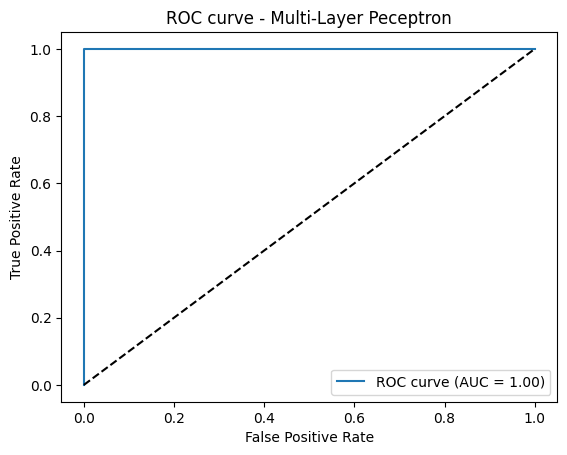

Soglia ottimale suggerita: 0.7409


In [ ]:
fpr, tpr, thresholds = roc_curve(label_test, mlp_predictions_prob)
mlp_roc_auc = auc(fpr, tpr)

mlp_optimal_idx = np.argmax(tpr - fpr)
mlp_optimal_threshold = thresholds[mlp_optimal_idx]

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {mlp_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Multi-Layer Peceptron")
plt.legend()
plt.show()


print(f"Soglia ottimale suggerita: {mlp_optimal_threshold:.4f}")

La curva ROC del MLP sale subito verso l’angolo in alto a sinistra, e l’AUC è 1: il massimo possibile.
Vuol dire che il modello distingue perfettamente tra attacchi e dati normali, senza sbagliare nemmeno una volta.
In pratica, qualunque soglia scelgo, il modello è sempre in grado di separare bene le due classi, quindi è davvero preciso.
La soglia ottimale trovata è circa 0.74, cioè se la probabilità prevista dal MLP è più alta di questo valore, il modello classifica il dato come attacco.

Ora plotto i risultati calcolati precedentemente per il modello VAE.

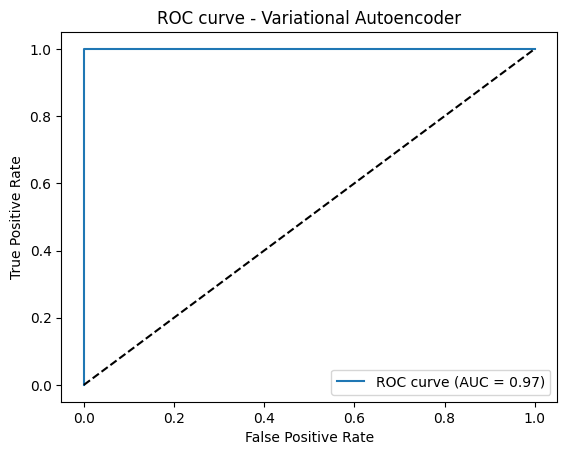

Soglia ottimale suggerita: 0.0520


In [ ]:
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {vae_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Variational Autoencoder")
plt.legend()
plt.show()

print(f"Soglia ottimale suggerita: {vae_optimal_threshold:.4f}")

La curva ROC del VAE è molto buona, con un’AUC di 0.97: vuol dire che il modello riconosce quasi tutti gli attacchi e fa pochi errori.
La soglia ottimale trovata è circa 0.052: vuol dire che, se l’errore di ricostruzione è più alto di questo valore, il dato viene considerato un attacco.

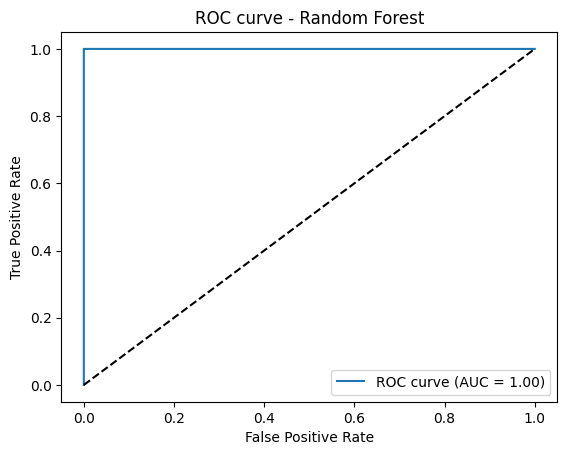

Soglia ottimale suggerita: 0.5450


In [ ]:
fpr, tpr, thresholds = roc_curve(label_test, y_rf_proba)
rf_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {rf_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - Random Forest")
plt.legend()
plt.show()

rf_optimal_idx = np.argmax(tpr - fpr)
rf_optimal_threshold = thresholds[rf_optimal_idx]
print(f"Soglia ottimale suggerita: {rf_optimal_threshold:.4f}")

La curva ROC della Random Forest è praticamente perfetta, con un’AUC di 1.00.
Anche qui il modello separa senza errori attacchi e dati normali, come già visto per il MLP.
La soglia ottimale trovata è circa 0.545: se la probabilità supera questo valore, il dato viene considerato un attacco.

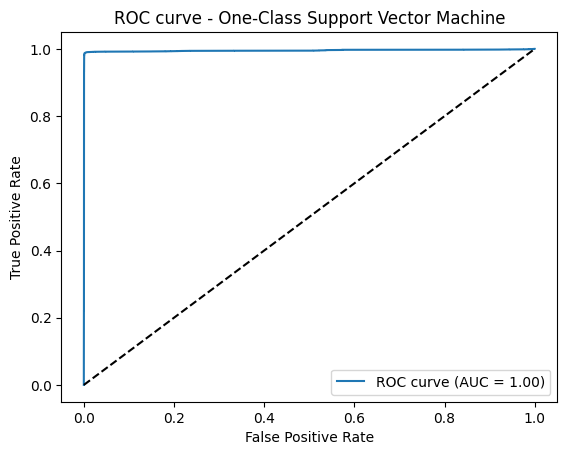

Soglia ottimale suggerita: 1.9715


In [ ]:
ocsvm_scores = ocsvm_model.decision_function(test_set)

fpr, tpr, thresholds = roc_curve(label_test, -ocsvm_scores)
ocsvm_roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {ocsvm_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - One-Class Support Vector Machine")
plt.legend()
plt.show()

ocsvm_optimal_idx = np.argmax(tpr - fpr)
ocsvm_optimal_threshold = thresholds[ocsvm_optimal_idx]
print(f"Soglia ottimale suggerita: {ocsvm_optimal_threshold:.4f}")

La curva ROC della One-Class SVM è molto alta, con AUC pari a 1.00: anche questo modello separa benissimo i casi normali dagli attacchi.
La soglia ottimale trovata è circa 1.97: sopra questo valore il dato viene considerato normale, sotto viene classificato come attacco.

Per confrontare meglio gli errori commessi dai vari modelli, calcolo e visualizzo la matrice di confusione per ciascuno di essi.  
Il codice è identico per tutti i modelli, cambia solo la variabile delle predizioni che uso:

- Per il MLP: `mlp_cm = confusion_matrix(label_test, mlp_predictions_class)`
- Per il VAE: `vae_cm = confusion_matrix(label_test, vae_pred)`
- Per la Random Forest: `rf_cm = confusion_matrix(label_test, y_rf_pred)`
- Per la One-Class SVM: `ocsvm_cm = confusion_matrix(label_test, ocsvm_y_pred)`

Le matrici vengono poi plottate nello stesso modo usando matplotlib, cambiando solo il titolo del grafico in base al modello.

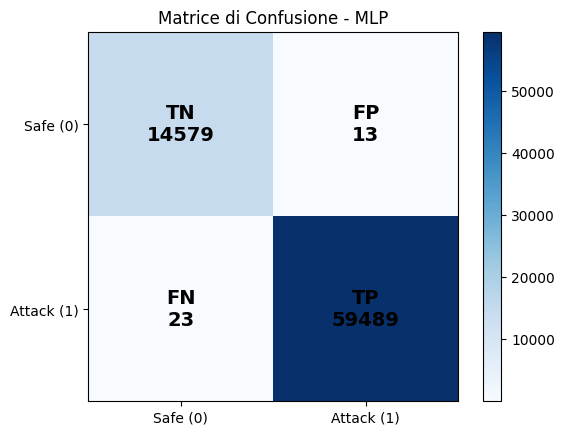

In [ ]:
mlp_cm = confusion_matrix(label_test, mlp_predictions_class)

mlp_fig, mlp_ax = plt.subplots()

mlp_im = mlp_ax.imshow(mlp_cm, cmap=plt.cm.Blues)

labels = [
  f'TN\n{mlp_cm[0,0]}',
  f'FP\n{mlp_cm[0,1]}',
  f'FN\n{mlp_cm[1,0]}',
  f'TP\n{mlp_cm[1,1]}'
]
positions = [(0,0), (0,1), (1,0), (1,1)]

for (i, j), label in zip(positions, labels):
  mlp_ax.text(j, i, label, ha='center', va='center', color='black', fontsize=14, fontweight='bold')

mlp_ax.set_xticks([0,1])
mlp_ax.set_yticks([0,1])
mlp_ax.set_xticklabels(['Safe (0)', 'Attack (1)'])
mlp_ax.set_yticklabels(['Safe (0)', 'Attack (1)'])

plt.title('Matrice di Confusione - MLP')
plt.colorbar(mlp_im)
plt.show()

La matrice di confusione del MLP mostra che il modello sbaglia pochissimo:  
- I casi “normali” (Safe) sono quasi tutti riconosciuti correttamente (14579 su 14592).
- Gli attacchi vengono identificati quasi sempre, con 59489 su 59512 predetti giusti.
- Solo 13 casi normali sono stati classificati per errore come attacchi (falsi positivi), e solo 23 attacchi non sono stati riconosciuti (falsi negativi).

In pratica, il modello distingue benissimo tra traffico normale e attacchi, commettendo solo errori minimi rispetto alla dimensione del test set.

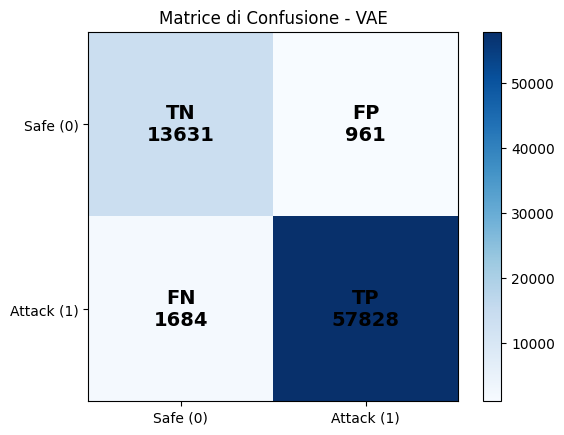

In [ ]:
vae_cm = confusion_matrix(label_test, y_vae_pred)

vae_fig, vae_ax = plt.subplots()

vae_im = vae_ax.imshow(vae_cm, cmap=plt.cm.Blues)

labels_vae = [
  f'TN\n{vae_cm[0,0]}',
  f'FP\n{vae_cm[0,1]}',
  f'FN\n{vae_cm[1,0]}',
  f'TP\n{vae_cm[1,1]}'
]
positions_vae = [(0,0), (0,1), (1,0), (1,1)]

for (i, j), label in zip(positions_vae, labels_vae):
  vae_ax.text(j, i, label, ha='center', va='center', color='black', fontsize=14, fontweight='bold')

vae_ax.set_xticks([0,1])
vae_ax.set_yticks([0,1])
vae_ax.set_xticklabels(['Safe (0)', 'Attack (1)'])
vae_ax.set_yticklabels(['Safe (0)', 'Attack (1)'])

plt.title('Matrice di Confusione - VAE')
plt.colorbar(vae_im)
plt.show()

Guardando la matrice di confusione del VAE, si vede che il modello fa comunque un buon lavoro, ma commette più errori rispetto al MLP:
- Riconosce correttamente la maggior parte dei casi normali (13631 su 14592), ma sbaglia 961 volte classificando normali come attacchi (falsi positivi).
- Individua molti attacchi (57828 su 59512), ma ne manca 1684 che vengono scambiati per casi normali (falsi negativi).

In sintesi, il VAE non è precisissimo: riesce a trovare la maggior parte degli attacchi, ma tende a generare qualche falso allarme in più e a lasciarsi sfuggire alcuni attacchi.

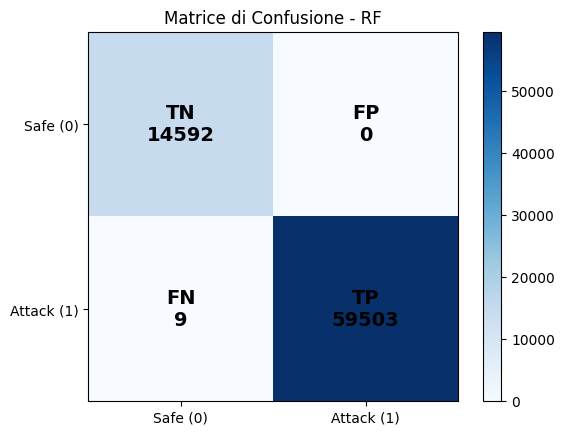

In [ ]:
rf_cm = confusion_matrix(label_test, y_rf_pred)

rf_fig, rf_ax = plt.subplots()

rf_im = rf_ax.imshow(rf_cm, cmap=plt.cm.Blues)

labels_rf = [
  f"TN\n{rf_cm[0,0]}",
  f"FP\n{rf_cm[0,1]}",
  f"FN\n{rf_cm[1,0]}",
  f"TP\n{rf_cm[1,1]}"
]
positions_rf = [(0,0), (0,1), (1,0), (1,1)]

for (i, j), label in zip(positions_rf, labels_rf):
    rf_ax.text(j, i, label, ha='center', va='center', color='black', fontsize=14, fontweight='bold')

rf_ax.set_xticks([0, 1])
rf_ax.set_yticks([0, 1])
rf_ax.set_xticklabels(['Safe (0)', 'Attack (1)'])
rf_ax.set_yticklabels(['Safe (0)', 'Attack (1)'])

plt.title('Matrice di Confusione - RF')
plt.colorbar(rf_im)
plt.show()


La matrice di confusione della Random Forest è praticamente perfetta:
- Tutti i dati normali sono riconosciuti correttamente (14592 su 14592) e non ci sono falsi positivi (0 errori).
- Gli attacchi vengono quasi sempre identificati, con solo 9 casi mancati su 59512.

In pratica, la Random Forest non sbaglia quasi mai: nessun normale scambiato per attacco e solo pochissimi attacchi non riconosciuti.  

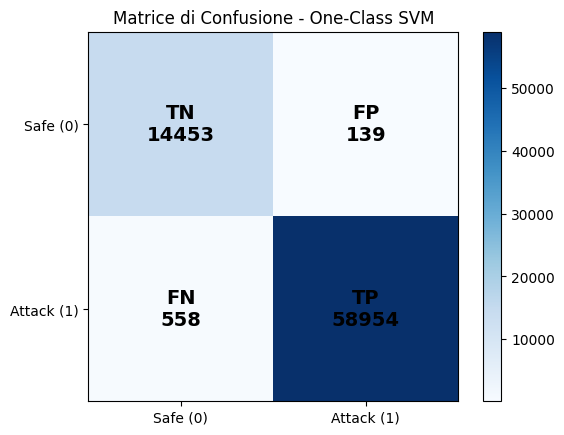

In [ ]:
ocsvm_cm = confusion_matrix(label_test, ocsvm_y_pred)  # y_pred è l’array di predizioni 0/1 del modello

ocsvm_fig, ocsvm_ax = plt.subplots()

ocsvm_im = ocsvm_ax.imshow(ocsvm_cm, cmap=plt.cm.Blues)

labels = [
    f"TN\n{ocsvm_cm[0,0]}",
    f"FP\n{ocsvm_cm[0,1]}",
    f"FN\n{ocsvm_cm[1,0]}",
    f"TP\n{ocsvm_cm[1,1]}"
]
positions = [(0,0), (0,1), (1,0), (1,1)]

for (i, j), label in zip(positions, labels):
    ocsvm_ax.text(j, i, label, ha='center', va='center', color='black', fontsize=14, fontweight='bold')

ocsvm_ax.set_xticks([0, 1])
ocsvm_ax.set_yticks([0, 1])
ocsvm_ax.set_xticklabels(['Safe (0)', 'Attack (1)'])
ocsvm_ax.set_yticklabels(['Safe (0)', 'Attack (1)'])

plt.title('Matrice di Confusione - One-Class SVM')
plt.colorbar(ocsvm_im)
plt.show()

La matrice di confusione della One-Class SVM mostra che il modello fa comunque un buon lavoro:
- Riconosce la maggior parte dei dati normali (14453 su 14592), ma sbaglia 139 volte classificando dei normali come attacchi (falsi positivi).
- Trova la quasi totalità degli attacchi (58954 su 59512), ma ne manca 558 che vengono scambiati per casi normali (falsi negativi).

In sintesi, la One-Class SVM si comporta bene, anche se genera qualche falso allarme in più e si lascia sfuggire un po’ più di attacchi.  
I risultati sono comunque molto buoni.

# Analisi della trasparenza e delle feature più importanti

Per capire quali variabili influenzano di più le decisioni dei modelli, ho calcolato la Permutation Feature Importance per ciascun modello.
Per tutti, riporto le 20 feature che, se alterate, peggiorano di più la capacità di rilevare gli attacchi.

## Analisi delle feature più rilevanti per ciascun modello

Estraggo tutti i nomi delle feature dal dataset per usarli nei grafici delle importanze.

In [ ]:
feature_names = X.columns.tolist()

In questa cella calcolo la Permutation Feature Importance, cioè quanto ogni variabile incide sulla capacità del modello di riconoscere attacchi.

- Adatto il modello MLP per essere compatibile con la funzione di permutazione, creando una piccola classe wrapper.
- Applico la PermutationImportance di eli5, che valuta per ciascuna feature quanto peggiora la performance (F1-score) quando viene mescolata a caso.
- Ordino e seleziono le 20 feature più importanti secondo il modello.
- Visualizzo i risultati con un grafico a barre.



2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2316/2316 ━

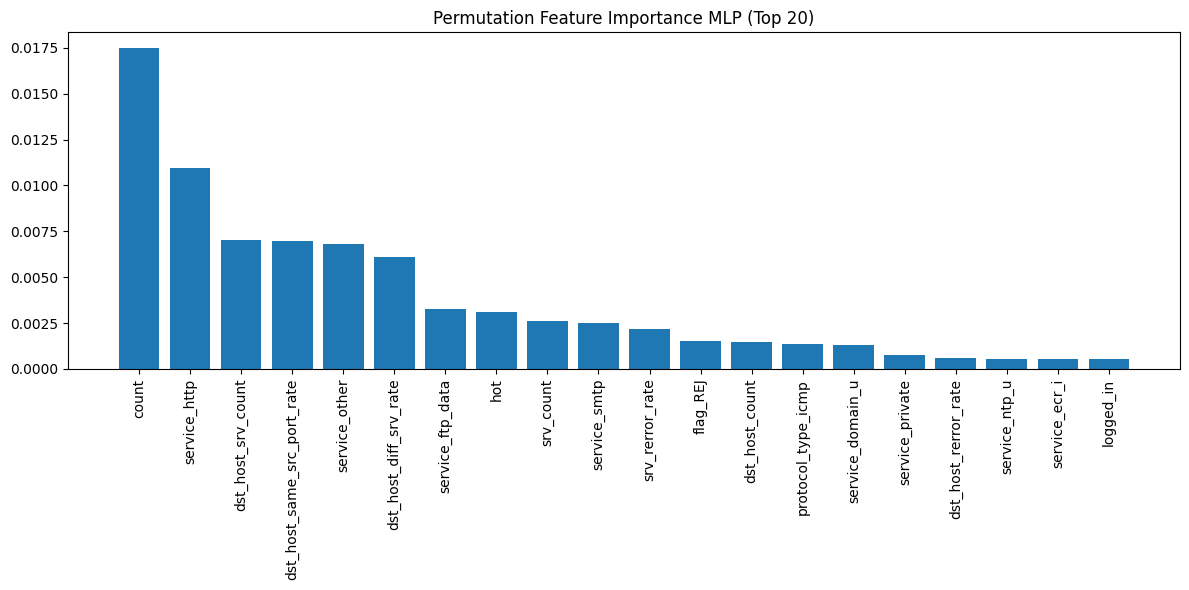

In [ ]:
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        return self
    def predict_proba(self, X):
        preds = self.model.predict(X)
        return np.hstack([1 - preds, preds])
    def predict(self, X):
        preds = self.model.predict(X)
        return (preds.flatten() >= 0.5).astype(int)

wrapped_model = KerasModelWrapper(mlp_model)

perm = PermutationImportance(
    wrapped_model,
    random_state=42,
    scoring='f1',
    n_iter=2
)
perm.fit(test_set, label_test)

eli5.show_weights(perm, feature_names=feature_names)

mlp_importances = perm.feature_importances_
mlp_indices = np.argsort(mlp_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Permutation Feature Importance MLP (Top 20)")
plt.bar(range(20), mlp_importances[mlp_indices][:20], align='center')
plt.xticks(range(20), np.array(feature_names)[mlp_indices][:20], rotation=90)
plt.tight_layout()
plt.show()

Dal grafico si vede che la variabile più importante per il modello MLP è `count`, cioè il numero di connessioni, che ha molto più peso delle altre.
Seguono `service_http` e varie statistiche sugli host (`dst_host_srv_count`, `dst_host_same_src_port_rate`), che sono anch’esse molto influenti.
Altre variabili importanti sono legate al tipo di servizio e a parametri particolari delle connessioni.

In generale, le prime feature in classifica sono quelle che il modello considera più utili per distinguere tra traffico normale e attacchi.

In questa cella viene calcolata la Permutation Feature Importance per il VAE.
Il codice lavora così:
- Per ogni feature del test set, crea una copia dei dati e mescola solo quella colonna.
- Calcola poi l’errore di ricostruzione del VAE sui dati modificati e vede quanto peggiora la curva ROC rispetto ai dati non alterati.
- Se la performance del modello cala molto quando una feature viene mescolata, vuol dire che quella variabile è molto importante per riconoscere le anomalie.


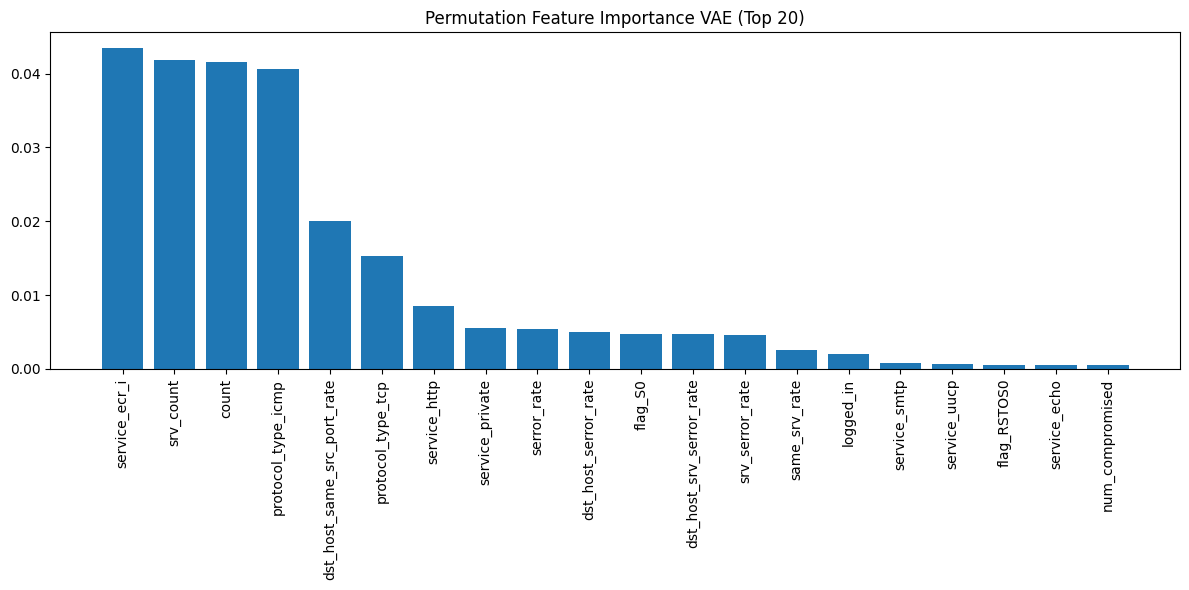

In [ ]:
vae_importances = []
for col in range(test_set.shape[1]):
    test_shuffled = test_set.copy()
    np.random.shuffle(test_shuffled[:, col])
    z_mean, z_log_var = vae_model.encoder(test_shuffled)
    z = vae_model.sampler(z_mean, z_log_var)
    reconstructions = vae_model.decoder(z)
    errors = np.mean((test_shuffled - reconstructions.numpy())**2, axis=1)
    fpr_shuff, tpr_shuff, _ = roc_curve(label_test, errors)
    auc_shuff = auc(fpr_shuff, tpr_shuff)
    vae_importances.append(vae_roc_auc - auc_shuff)

vae_importances = np.array(vae_importances)
vae_indices = np.argsort(vae_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Permutation Feature Importance VAE (Top 20)")
plt.bar(range(20), vae_importances[vae_indices][:20], align='center')
plt.xticks(range(20), np.array(feature_names)[vae_indices][:20], rotation=90)
plt.tight_layout()
plt.show()

Nel grafico si nota che `service_ecr_i`, `srv_count` e `count` sono le features che, se modificate, peggiorano di più la capacità del VAE di distinguere tra traffico normale e attacchi.
Anche altre variabili legate al tipo di servizio, al protocollo e alle statistiche sulle connessioni risultano rilevanti.

In questa cella seleziono il miglior modello Random Forest trovato dal GridSearch (`best_estimator_`)  
e salvo nella variabile `rf_importances` le importanze delle feature calcolate dal modello.

In [ ]:
rf_best = rf_model.best_estimator_
rf_importances = rf_best.feature_importances_

Qui ordino le feature in base all’importanza e plotto il grafico a barre.



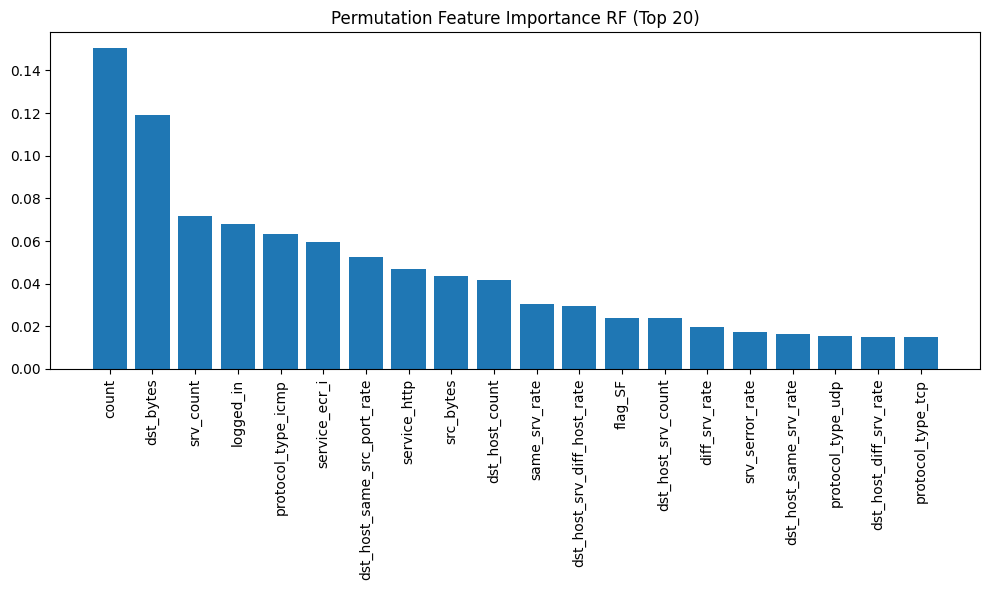

In [ ]:
rf_best = rf_model.best_estimator_
rf_importances = rf_best.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance RF (Top 20)")
plt.bar(range(20), rf_importances[rf_indices][:20], align='center')
plt.xticks(range(20), np.array(feature_names)[rf_indices][:20], rotation=90)
plt.tight_layout()
plt.show()

Dal grafico si vede che la variabile `count` è nettamente la più importante per la Random Forest:  
è quella che più di tutte influenza le decisioni del modello.  
Seguono `dst_bytes`, `srv_count` e `logged_in`, oltre a variabili legate ai protocolli e alle statistiche delle connessioni.

In questa cella calcolo la Permutation Feature Importance per la One-Class SVM:
- Per ogni feature del test set, creo una copia dei dati e mescolo la colonna.
- Calcolo i punteggi della One-Class SVM sui dati modificati e vedo quanto peggiora la curva ROC rispetto all’originale.
- Più cala l’AUC quando una feature viene mescolata, più quella variabile è considerata importante dal modello.
- Alla fine ordino le feature e disegno il grafico a barre delle 20 più rilevanti.


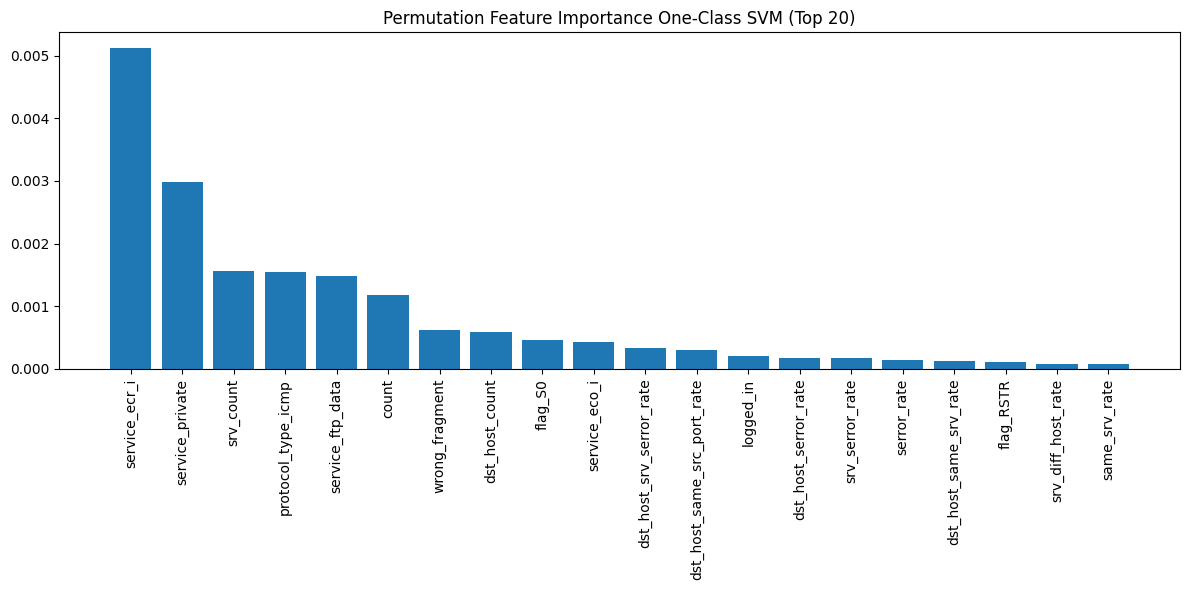

In [ ]:
ocsvm_importances = []
for col in range(test_set.shape[1]):
    test_shuffled = test_set.copy()
    np.random.shuffle(test_shuffled[:, col])
    shuffled_scores = ocsvm_model.decision_function(test_shuffled)
    fpr_shuff, tpr_shuff, _ = roc_curve(label_test, -shuffled_scores)
    auc_shuff = auc(fpr_shuff, tpr_shuff)
    ocsvm_importances.append(ocsvm_roc_auc - auc_shuff)

ocsvm_importances = np.array(ocsvm_importances)
ocsvm_indices = np.argsort(ocsvm_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Permutation Feature Importance One-Class SVM (Top 20)")
plt.bar(range(20), ocsvm_importances[ocsvm_indices][:20], align='center')
plt.xticks(range(20), np.array(feature_names)[ocsvm_indices][:20], rotation=90)
plt.tight_layout()
plt.show()

Dal grafico si vede che la feature più importante per la One-Class SVM è `service_ecr_i`, che risulta avere il maggior impatto nel riconoscere dati anomali.  
A seguire troviamo variabili come `service_private`, `srv_count` e `protocol_type_icmp`, tutte legate ai tipi di servizio e alla natura delle connessioni nel dataset.  
Anche feature come `service_ftp_data` e `count` sono considerate rilevanti dal modello, mentre le altre variabili nell’elenco hanno un’influenza minore.

## Commento sull’interpretabilità delle decisioni

In [ ]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Rank", "MLP", "VAE", "RF", "One-Class SVM"]

for i in range(10):
    row = [i+1,
           feature_names[mlp_indices[i]],
           feature_names[vae_indices[i]],
           feature_names[rf_indices[i]],
           feature_names[ocsvm_indices[i]]]
    table.add_row(row)

print(table)


+------+-----------------------------+-----------------------------+-----------------------------+--------------------+
| Rank |             MLP             |             VAE             |              RF             |   One-Class SVM    |
+------+-----------------------------+-----------------------------+-----------------------------+--------------------+
|  1   |            count            |        service_ecr_i        |            count            |   service_ecr_i    |
|  2   |         service_http        |          srv_count          |          dst_bytes          |  service_private   |
|  3   |      dst_host_srv_count     |            count            |          srv_count          |     srv_count      |
|  4   | dst_host_same_src_port_rate |      protocol_type_icmp     |          logged_in          | protocol_type_icmp |
|  5   |        service_other        | dst_host_same_src_port_rate |      protocol_type_icmp     |  service_ftp_data  |
|  6   |    dst_host_diff_srv_rate   |  

La tabella mostra le 10 feature più importanti per ciascun modello secondo la Permutation Feature Importance.  
Si nota che alcune variabili compaiono spesso tra le prime posizioni per tutti i modelli: ad esempio, `count` (il numero di connessioni) è ai primi posti sia per MLP che per Random Forest e VAE, mentre `srv_count` è presente in tutte le classifiche.  
Anche i servizi particolari come `service_ecr_i`, `service_http` e `service_private` sono ricorrenti, soprattutto per VAE e One-Class SVM, che danno più peso a feature legate a servizi rari o sospetti.  
Altre variabili come `protocol_type_icmp`, `dst_host_same_src_port_rate` e alcune statistiche sugli host compaiono frequentemente, segno che il tipo di protocollo e il comportamento degli host sono fattori chiave per individuare gli attacchi.

In generale, anche se ogni modello può ordinare le feature in modo leggermente diverso, c’è un nucleo di variabili che risultano sempre molto importanti.  
Questo rafforza l’idea che certi indicatori, come il numero di connessioni e i servizi utilizzati, sono fondamentali per distinguere tra traffico normale e attività anomala in questo dataset.


# Discussione finale e possibili estensioni

Il confronto tra modelli supervisionati (MLP e Random Forest) e non supervisionati (VAE e One-Class SVM) ha mostrato che tutti gli approcci testati sono risultati estremamente efficaci nell’identificazione degli attacchi informatici sul dataset KDD CUP 1999, con valori di F1-score e AUC vicini a 1.

**Random Forest** si conferma il modello più robusto e preciso, raggiungendo risultati praticamente perfetti, mentre il MLP si avvicina a performance ideali, con pochissimi errori. Anche i modelli non supervisionati (VAE e One-Class SVM) si sono dimostrati molto validi per l’anomaly detection: riescono a individuare la grande maggioranza degli attacchi, pur generando un numero maggiore di falsi positivi e negativi rispetto ai supervisionati. Questo dimostra che anche in assenza di etichette è possibile ottenere ottimi risultati nella rilevazione automatica delle intrusioni.

L’analisi della feature importance ha messo in evidenza alcune variabili chiave ricorrenti in tutti i modelli, confermando la solidità delle informazioni presenti nel dataset e la coerenza delle strategie di apprendimento. In particolare, feature come `count`, `srv_count` e alcuni servizi specifici si sono rivelati fondamentali per distinguere attacchi da traffico normale.

Tra i **limiti principali** di questo lavoro vanno segnalati:
- L’utilizzo di un solo dataset, peraltro piuttosto datato.
- La natura sintetica degli attacchi simulati.
- La mancanza di un vero scenario real-time, che rende difficile valutare la reale applicabilità delle soluzioni in contesti di rete moderni e dinamici.

**Possibili estensioni** future di questo progetto includono:
- Applicazione e test della pipeline su dataset più recenti e realistici, per validare la robustezza dei modelli in contesti attuali.
- Integrazione di tecniche di data augmentation o di generazione tramite GAN per simulare nuovi tipi di attacco.
- Sperimentazione di un’implementazione in tempo reale, collegando il modello a flussi di traffico di rete veri per valutarne la reattività e l’efficacia sul campo.